In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgboost

from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

import joblib

In [181]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [182]:
def create_model():
    from tensorflow import keras
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [183]:
from sklvq import GMLVQ as BaseGMLVQ
class CustomGMLVQ(BaseGMLVQ):
    def predict(self, X):
        decision_values = self.decision_function(X)
        
        if self.classes_.size == 2:
            return self.classes_[(decision_values > 0).astype(np.int64)]  # Changed from np.int to np.int64
        
        return self.classes_[decision_values.argmax(axis=1)]


In [184]:
c_mlp = joblib.load('models/committee_mlp.pkl')
dt = joblib.load('models/dt.pkl')
knn = joblib.load('models/knn.pkl')
lgbm = joblib.load('models/lightgbm.pkl')
lvq = joblib.load('models/lvq.pkl')
mlp = joblib.load('models/mlp.pkl')
rf = joblib.load('models/rf.pkl')
svm = joblib.load('models/svc.pkl')
# xgb = joblib.load('models/xg.pkl') #Teve que passar por uma função alternativa




c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator

In [185]:
try:
    xgb = joblib.load('models/xg.pkl')

    # If not an instance of XGBClassifier, reinitialize it
    if not isinstance(xgb, xgboost.XGBClassifier):
        print("Reinitializing as XGBClassifier...")
        new_xgb = xgboost.XGBClassifier()
        new_xgb._Booster = xgb.get_booster()  # Transfer the booster
        new_xgb.set_params(**xgb.get_xgb_params())  # Copy parameters
        xgb = new_xgb

    print("XGBoost model loaded successfully.")

except Exception as e:
    print(f"Error loading XGBoost model: {e}")
    xgb = xgboost.XGBClassifier()  # Fallback to a new instance

# Monkey-patch the model to add a dummy 'feature_weights' attribute if missing.
if not hasattr(xgb, "feature_weights"):
    try:
        # Use the number of features if available
        xgb.feature_weights = np.ones(xgb.n_features_in_)
    except AttributeError:
        # Fallback: use the number of columns in X_train
        xgb.feature_weights = np.ones(X_train.shape[1])

XGBoost model loaded successfully.


In [186]:
base_models = [
    ('knn', knn),
    ('svm', svm),
    ('rf', rf),
    ('mlp', mlp),
    ('xgb', xgb)
]

In [187]:
meta_model = LogisticRegression()

In [188]:
stacking_knn_svm_rf_mlp_xgb = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [189]:
stacking_knn_svm_rf_mlp_xgb.fit(X_train, y_train)

c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

StackingClassifier(cv=5,
                   estimators=[('knn',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=1)),
                               ('svm',
                                Pipeline(steps=[('oversampler',
                                                 RandomOverSampler(random_state=42)),
                                                ('svc',
                                                 SVC(C=100, gamma=0.01))])),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=50,
                                                       max_features='log2',
                                                       min_samples_leaf=4,
                                                       n_estimators=500,
                                                       random_state=42)),
                               ('mlp',
                                P...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.05, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=3, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=500, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression())

In [190]:
y_pred_knn_svm_rf_mlp_xgb = stacking_knn_svm_rf_mlp_xgb.predict(X_test)
print(classification_report(y_test, y_pred_knn_svm_rf_mlp_xgb, digits=4))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn_svm_rf_mlp_xgb):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_knn_svm_rf_mlp_xgb, average='macro'):.4f}")

              precision    recall  f1-score   support

           0     0.8950    0.9543    0.9237      2100
           1     0.6509    0.4324    0.5196       414

    accuracy                         0.8683      2514
   macro avg     0.7730    0.6933    0.7217      2514
weighted avg     0.8548    0.8683    0.8572      2514

Accuracy: 0.8683
F1-score (macro): 0.7217


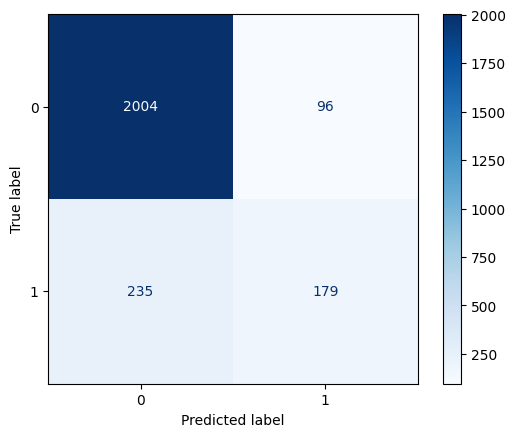

In [191]:
cm = confusion_matrix(y_test, y_pred_knn_svm_rf_mlp_xgb)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='Blues')

In [192]:
base_models = [
    ('knn', knn),
    ('rf', rf),
    ('mlp', mlp)
]

In [193]:
stacking_knn_rf_mlp = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [194]:
stacking_knn_rf_mlp.fit(X_train, y_train)

c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

StackingClassifier(cv=5,
                   estimators=[('knn',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=1)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=50,
                                                       max_features='log2',
                                                       min_samples_leaf=4,
                                                       n_estimators=500,
                                                       random_state=42)),
                               ('mlp',
                                Pipeline(steps=[('oversampler',
                                                 SMOTE(random_state=42)),
                                                ('mlp',
                                                 MLPClassifier(activation='tanh',
                                                               alpha=0.001,
                                                               hidden_layer_sizes=(50,)))]))],
                   final_estimator=LogisticRegression())

In [195]:
y_pred_knn_rf_mlp = stacking_knn_rf_mlp.predict(X_test)
print(classification_report(y_test, y_pred_knn_rf_mlp, digits=4))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn_rf_mlp):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_knn_rf_mlp, average='macro'):.4f}")

              precision    recall  f1-score   support

           0     0.8863    0.9543    0.9191      2100
           1     0.6206    0.3792    0.4708       414

    accuracy                         0.8596      2514
   macro avg     0.7534    0.6668    0.6949      2514
weighted avg     0.8426    0.8596    0.8452      2514

Accuracy: 0.8596
F1-score (macro): 0.6949


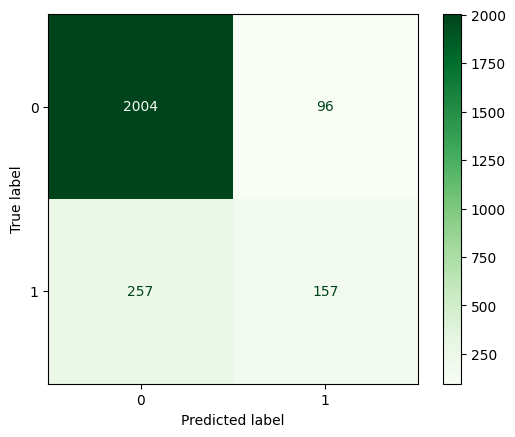

In [197]:
cm = confusion_matrix(y_test, y_pred_knn_rf_mlp)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='Greens')

In [198]:
base_models = [
    ('knn', knn),
    ('xgb', xgb),
    ('lgbm', lgbm)
]

In [199]:
stacking_knn_xgb_lgbm = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [200]:
stacking_knn_xgb_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 966, number of negative: 4898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 5864, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 773, number of negative: 3918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 4691, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM]

c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 773, number of negative: 3918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 4691, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 773, number of negative: 3918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 4691, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 772, number of negative: 3919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 4691, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 773, number of negative: 3919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 4692, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('knn',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=arra...
                                              learning_rate=0.05, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=3, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=500, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgbm',
                                LGBMClassifier(class_weight='balanced',
                                               random_state=42))],
                   final_estimator=LogisticRegression())

In [201]:
y_pred_knn_xgb_lgbm = stacking_knn_xgb_lgbm.predict(X_test)
print(classification_report(y_test, y_pred_knn_xgb_lgbm, digits=4))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn_xgb_lgbm):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_knn_xgb_lgbm, average='macro'):.4f}")

              precision    recall  f1-score   support

           0     0.9018    0.9448    0.9228      2100
           1     0.6306    0.4783    0.5440       414

    accuracy                         0.8679      2514
   macro avg     0.7662    0.7115    0.7334      2514
weighted avg     0.8572    0.8679    0.8604      2514

Accuracy: 0.8679
F1-score (macro): 0.7334


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


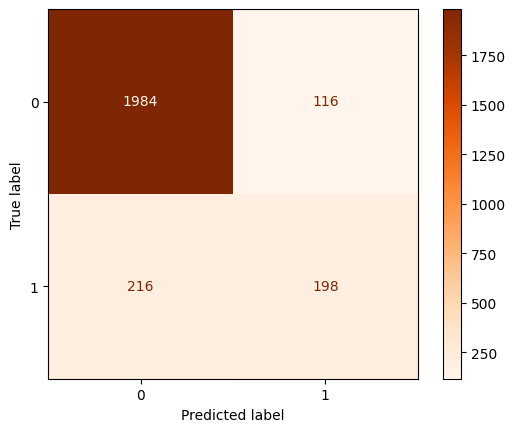

In [203]:
cm = confusion_matrix(y_test, y_pred_knn_xgb_lgbm)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='Oranges')

In [204]:
base_models = [
    ('lvq', lvq),
    ('svm', svm),
    ('mlp', mlp)
]

In [205]:
stacking_lvq_svm_mlp = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [206]:
stacking_lvq_svm_mlp.fit(X_train, y_train)

c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be r

StackingClassifier(cv=5,
                   estimators=[('lvq',
                                CustomGMLVQ(solver_params={'step_size': 0.001})),
                               ('svm',
                                Pipeline(steps=[('oversampler',
                                                 RandomOverSampler(random_state=42)),
                                                ('svc',
                                                 SVC(C=100, gamma=0.01))])),
                               ('mlp',
                                Pipeline(steps=[('oversampler',
                                                 SMOTE(random_state=42)),
                                                ('mlp',
                                                 MLPClassifier(activation='tanh',
                                                               alpha=0.001,
                                                               hidden_layer_sizes=(50,)))]))],
                   final_estimator=LogisticRegression())

In [207]:
y_pred_lvq_svm_mlp = stacking_lvq_svm_mlp.predict(X_test)
print(classification_report(y_test, y_pred_lvq_svm_mlp, digits=4))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lvq_svm_mlp):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_lvq_svm_mlp, average='macro'):.4f}")

c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0     0.8818    0.9519    0.9155      2100
           1     0.5911    0.3527    0.4418       414

    accuracy                         0.8532      2514
   macro avg     0.7364    0.6523    0.6786      2514
weighted avg     0.8339    0.8532    0.8375      2514

Accuracy: 0.8532
F1-score (macro): 0.6786


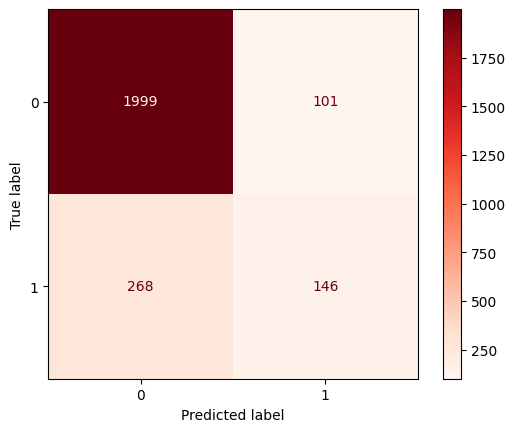

In [208]:
cm = confusion_matrix(y_test, y_pred_lvq_svm_mlp)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='Reds')

In [209]:
base_models = [
    ('dt', dt),
    ('rf', rf),
    ('knn', knn),
    ('svm', svm),
    ('mlp', mlp),
    ('xgb', xgb),
    ('lgbm', lgbm)
]

In [210]:
stacking_dt_rf_knn_svm_mlp_xgb_lgbm = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [211]:
stacking_dt_rf_knn_svm_mlp_xgb_lgbm.fit(X_train, y_train)

c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 966, number of negative: 4898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 5864, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[LightGBM] [Info] Number of positive: 773, number of negative: 3918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 4691, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 773, number of negative: 3918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 4691, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 773, number of negative: 3918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 4691, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 772, number of negative: 3919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 4691, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 773, number of negative: 3919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 4692, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=50,
                                                       max_features='log2',
                                                       min_samples_leaf=4,
                                                       n_estimators=500,
                                                       random_state=42)),
                               ('knn',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=1)),
                               ('svm',
                                Pipeline(steps=[('oversampler',
                                                 RandomOverSampler(random_state...
                                              learning_rate=0.05, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=3, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=500, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgbm',
                                LGBMClassifier(class_weight='balanced',
                                               random_state=42))],
                   final_estimator=LogisticRegression())

In [212]:
y_pred_dt_rf_knn_svm_mlp_xgb_lgbm = stacking_dt_rf_knn_svm_mlp_xgb_lgbm.predict(X_test)
print(classification_report(y_test, y_pred_dt_rf_knn_svm_mlp_xgb_lgbm, digits=4))
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_rf_knn_svm_mlp_xgb_lgbm):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_dt_rf_knn_svm_mlp_xgb_lgbm, average='macro'):.4f}")

              precision    recall  f1-score   support

           0     0.8992    0.9476    0.9228      2100
           1     0.6346    0.4614    0.5343       414

    accuracy                         0.8675      2514
   macro avg     0.7669    0.7045    0.7285      2514
weighted avg     0.8556    0.8675    0.8588      2514

Accuracy: 0.8675
F1-score (macro): 0.7285


c:\Users\brend\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


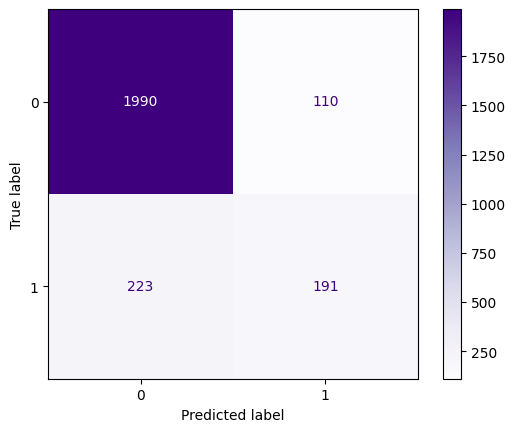

In [213]:
cm = confusion_matrix(y_test, y_pred_dt_rf_knn_svm_mlp_xgb_lgbm)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='Purples')

In [214]:
def save_best_model_auto(models_results: dict, y_true, metric: str = "f1_macro", path: str = "models/ch.pkl"):
    best_model_name = None
    best_model = None
    best_metric_value = -1

    print(f"\n🔍 Automatically evaluating models based on '{metric}':\n")

    for name, (model, y_pred) in models_results.items():
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        recall_1 = recall_score(y_true, y_pred, pos_label=1)

        metric_value = {
            'accuracy': acc,
            'f1_macro': f1,
            'recall_1': recall_1
        }.get(metric, -1)

        print(f"Model: {name}, Accuracy: {acc:.4f}, F1-macro: {f1:.4f}, Recall-1: {recall_1:.4f}")

        # Decide best
        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_model_name = name
            best_model = model

    # Save best model
    if best_model is not None:
        joblib.dump(best_model, path)
        print(f"\n✅ Best model '{best_model_name}' saved to '{path}' based on '{metric}' = {best_metric_value:.4f}")
    else:
        print("❌ No model was saved (check metric names and results).")


In [215]:
models_results = {
    'knn_svm_rf_mlp_xgb': (stacking_knn_svm_rf_mlp_xgb, y_pred_knn_svm_rf_mlp_xgb),
    'knn_rf_mlp': (stacking_knn_rf_mlp, y_pred_knn_rf_mlp),
    'knn_xgb_lgbm': (stacking_knn_xgb_lgbm, y_pred_knn_xgb_lgbm),
    'lvq_svm_mlp': (stacking_lvq_svm_mlp, y_pred_lvq_svm_mlp),
    'dt_rf_knn_svm_mlp_xgb_lgbm': (stacking_dt_rf_knn_svm_mlp_xgb_lgbm, y_pred_dt_rf_knn_svm_mlp_xgb_lgbm)
}

In [216]:
save_best_model_auto(models_results, y_test, metric='f1_macro', path='models/ch.pkl')


🔍 Automatically evaluating models based on 'f1_macro':

Model: knn_svm_rf_mlp_xgb, Accuracy: 0.8683, F1-macro: 0.7217, Recall-1: 0.4324
Model: knn_rf_mlp, Accuracy: 0.8596, F1-macro: 0.6949, Recall-1: 0.3792
Model: knn_xgb_lgbm, Accuracy: 0.8679, F1-macro: 0.7334, Recall-1: 0.4783
Model: lvq_svm_mlp, Accuracy: 0.8532, F1-macro: 0.6786, Recall-1: 0.3527
Model: dt_rf_knn_svm_mlp_xgb_lgbm, Accuracy: 0.8675, F1-macro: 0.7285, Recall-1: 0.4614

✅ Best model 'knn_xgb_lgbm' saved to 'models/ch.pkl' based on 'f1_macro' = 0.7334
